18.335 Class Project 

In [4]:
using LinearAlgebra
using SparseArrays
using PyPlot
using KrylovKit

In [5]:
#Given
p_max=8
m_max=55
l=2
#theta for double digit precision tol=2^(-53)
theta = [ 2.22045e-16  2.58096e-8  1.38635e-5  0.000339717  0.00240088  0.00906566  0.0238446  0.0499123  0.0895776  0.144183  0.214236  0.299616  0.399778  0.513915  0.641084  0.780287  0.930533  1.09086  1.26038  1.43825  1.62372  1.81608  2.01471  2.21905  2.42858  2.64285  2.86145  3.084  3.31017  3.53967  3.77221  4.00756  4.2455  4.48582  4.72835  4.97292  5.21938  5.46759  5.71744  5.9688  6.22158  6.47568  6.73102  6.9875  7.24507  7.50365  7.76317  8.02359  8.28485  8.5469  8.80969  9.07319  9.33734  9.60212  9.8675  10.1334  10.3999  10.6669  10.9343  11.2022  11.4705  11.7392  12.0084  12.2778  12.5477  12.8178  13.0883  13.3591  13.6302  13.9016  14.1732  14.4451  14.7172  14.9896  15.2622  15.535  15.808  16.0812  16.3546  16.6281  16.9019  17.1758  17.4498  17.724  17.9984  18.2729  18.5476  18.8223  19.0972  19.3723  19.6474  19.9227  20.198  20.4735  20.7491  21.0248  21.3005  21.5764  21.8523  22.1284] # load theta_taylor

1×100 Array{Float64,2}:
 2.22045e-16  2.58096e-8  1.38635e-5  …  21.3005  21.5764  21.8523  22.1284

In [6]:
#assuming double digit precision tol=2^(-53)
function parameters(A) #Corresponds to Algorithm 1 in the paper
    A1=opnorm(A,1)
    if A1<=4*theta[m_max]*p_max*(p_max+3)
        m_intermediate=zeros(m_max,1)
        for i=1:m_max
           m_intermediate[i]=i*ceil(A1/theta[i])
        end
        m_value=findmin(m_intermediate)
        m_opt=m_value[2][1]
        s_opt=ceil(opnorm(A,1)/theta[m_max])
    else
        p_intermediate=zeros(p_max-1,1)
        for i=2:p_max
            p_intermediate[i-1,1]=opnorm(A,i)
        end
         M = zeros(m_max,p_max-1);
        for p=2:p_max
            for m=p*(p-1)-1:m_max
                M[m,p-1]=m*ceil(p_intermediate[p-1,1]/theta[m])
            end
        end
        M=Float64.(M)
        zero_coord = findall(x->x==0, M)
        for cordval in zero_coord
            M[cordval] = Inf
        end
        c_star,m_star = findmin(M)
        s=size(M)
        m_opt=m_star[1]
        s_opt=max(c_star/m_opt,1)
    end
    return (m_opt,s_opt)
end 

parameters (generic function with 1 method)

In [7]:
function impexp(A,B) #corresponds to Algorithm 2 in the paper
    tol=2^(-53)
    n=size(A,1)
    o=size(A,2)
    mu=tr(A)/n
    A=A-mu*Matrix(1*I,n,o)
    if opnorm(A,1)==0
        m_opt=0
        s_opt=1
    else
       (m_opt,s_opt)=parameters(A)
    end
    F=B
    eta=exp(mu/s_opt)
    for i=1:s_opt
        c1=norm(B,Inf)
        for j=1:m_opt
            B=A*B/(s_opt*j)
            c2=norm(B,Inf)
            F=F+B
            if c1+c2<=tol*norm(F,Inf)
                break
            end
            c1=c2
        end
        F=eta*F
        B=F
    end
    return F
end


impexp (generic function with 1 method)

In [8]:
n=1000 #test case
A=sprand(n,n,0.5)
B=rand(n,1)
F=impexp(A,B)
G=exp(Matrix(A))*B
error=F-G
@show relative_error= norm(error,2)/norm(G,2)

relative_error = norm(error, 2) / norm(G, 2) = 5.719185906987316e-15

5.719185906987316e-15

In [9]:
function densityinv(n,d) #function to calculate relative error for different density
    A=sprand(n,n,d)
    B=rand(n,1)
    F=impexp(A,B)
    G=exp(Matrix(A))*B
    error=F-G
    relative_error= opnorm(error,2)/opnorm(G,2)
end

densityinv (generic function with 1 method)

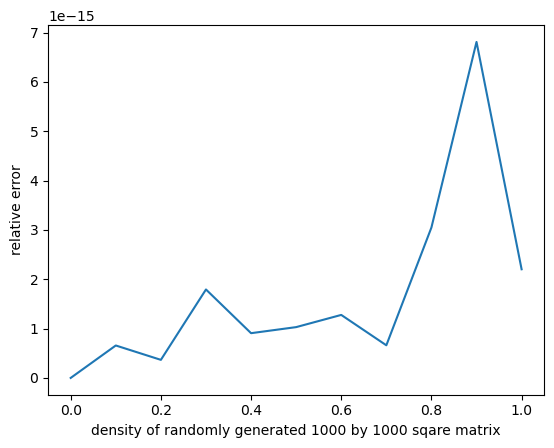

PyObject Text(0.5, 24.0, 'density of randomly generated 1000 by 1000 sqare matrix')

In [10]:
n=1000 #plotting of densityinv function
error_den=[ densityinv(n,d) for d=0:0.1:1]
x=0:0.1:1
plot(x,error_den)
ylabel("relative error")
xlabel("density of randomly generated 1000 by 1000 sqare matrix")
#title("relative error for sparse matrix as a function matrix density" )

In [11]:
function impexp_tol(A,B,tol) #function to compute relative error for different tolerance
   #tol=2^(-53)
    n=size(A,1)
    o=size(A,2)
    ref=exp(Matrix(A))*B
    mu=tr(A)/n
    A=A-mu*Matrix(1*I,n,o)
    if opnorm(A,1)==0
        m_opt=0
        s_opt=1
    else
       (m_opt,s_opt)=parameters(A)
    end
    F=B
    eta=exp(mu/s_opt)
    mv_product=0
    for i=1:s_opt
        c1=norm(B,Inf)
        for j=1:m_opt
            B=A*B/(s_opt*j)
            c2=norm(B,Inf)
            F=F+B
            mv_product=mv_product+1
            if c1+c2<=tol*norm(F,Inf)
                break
            end
            c1=c2
        end
        F=eta*F
        B=F
    end
    error=norm(F-ref,2)/norm(ref,2)
    return (mv_product,error)
end


impexp_tol (generic function with 1 method)

In [12]:
n=1000 #implementation of function impexp_tol and exponentiate from krylovkit 
A=sprand(n,n,0.1)
b=ones(n)#rand(n)
B=ones(n,1)#Matrix(b)
mvp=zeros(1,8)
error=zeros(1,8)
mvp2=zeros(1,8)
error2=zeros(1,8)
ref=exp(Matrix(A))*b
t=1
for i=1:8
    j=Float64(i*2)
    tol=10^(-j)
    tol2=tol
    F=impexp_tol(A,B,tol)
    mvp[i]=F[1]
    error[i]=F[2]
    y,info=exponentiate(A,t,b,tol=tol2)
    error2[i]=norm(y-ref,2)/norm(ref,2)
    mvp2[i]=info.numops
end


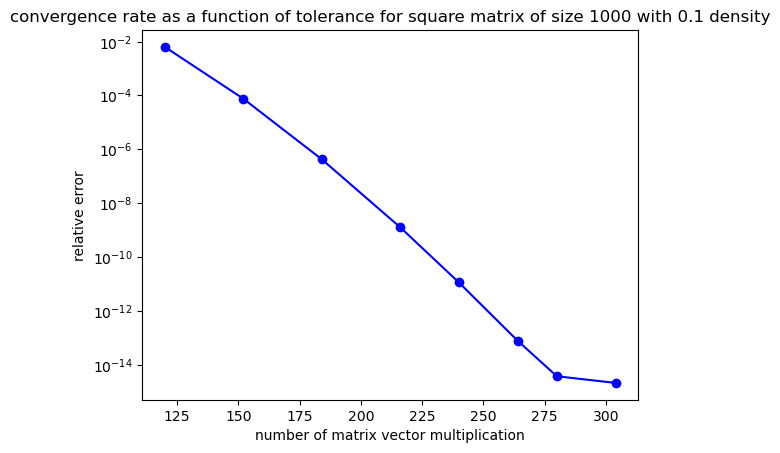

PyObject Text(0.5, 1.0, 'convergence rate as a function of tolerance for square matrix of size 1000 with 0.1 density')

In [13]:
using PyPlot
x=mvp[1:8]
y=error[1:8]
semilogy(x,y,"bo-")
ylabel("relative error")
xlabel("number of matrix vector multiplication")
title("convergence rate as a function of tolerance for square matrix of size 1000 with 0.1 density" )

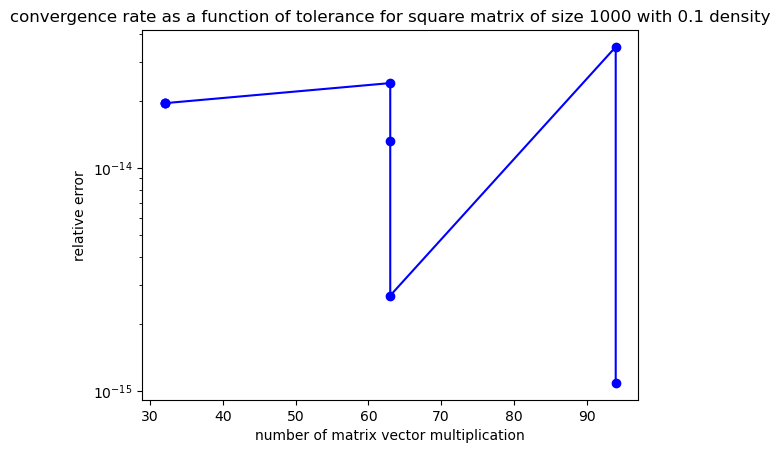

PyObject Text(0.5, 1.0, 'convergence rate as a function of tolerance for square matrix of size 1000 with 0.1 density')

In [14]:
using PyPlot
x2=mvp2[1:8]
y2=error2[1:8]
semilogy(x2,y2,"bo-")
ylabel("relative error")
xlabel("number of matrix vector multiplication")
title("convergence rate as a function of tolerance for square matrix of size 1000 with 0.1 density" )

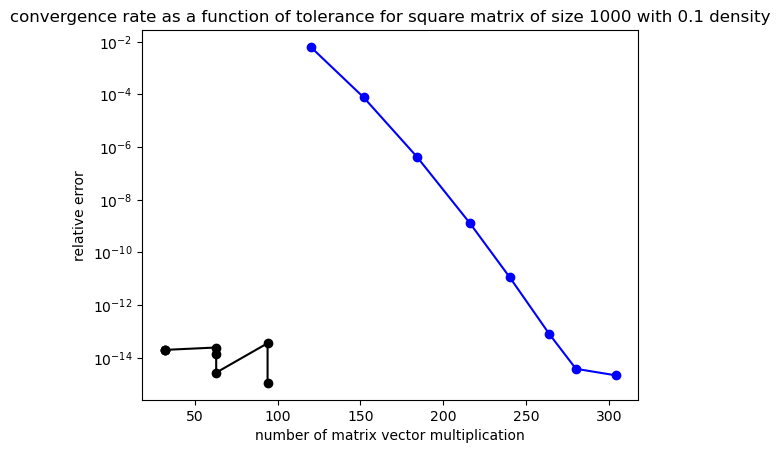

PyObject Text(0.5, 1.0, 'convergence rate as a function of tolerance for square matrix of size 1000 with 0.1 density')

In [15]:
semilogy(x,y,"bo-",x2,y2,"ko-") #performance comparision between impexp vs exponentiate from krylovkit
ylabel("relative error")
xlabel("number of matrix vector multiplication")
title("convergence rate as a function of tolerance for square matrix of size 1000 with 0.1 density" )